# Robust Principal Component Analysis Outlier Detector (RPCA-OD)

----

**Created by**:

- **Author**: Dr. Saad Laouadi
- **Date**: 19/08/2024

This notebook was created by dr. Saad Laouadi on August 19th, 2024 as part of a series on anomaly detection algorithms. The content is designed for researchers, data scientists, and practitioners interested in applying the Robust PCA Outlier Detector algorithm to identify anomalies in a dataset.

**Copyright**

**© 2024 Dr. Saad Laouadi. All rights reserved.**

---

## Table of Contents

## Table of Contents
1. [Objective](#Objective)
2. [Prerequisites](#Prerequisites)

---

## Objective




### Prerequisites



In [1]:
# ============================================================================================# 
#                                 Environment Setup
#  Here we import all the necessary modules and tools we will use through this notebook
# ============================================================================================# 
import os
import sys
import time
from collections import Counter

import numpy as np 
import pandas as pd
from scipy.io import arff

from pyod.models.abod import ABOD
from pyod.models.ecod import ECOD
from pyod.utils.data import evaluate_print
from pyod.utils.example import visualize
from pyod.models.auto_encoder import AutoEncoder

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve, auc
from sklearn.metrics import precision_score, recall_score, f1_score

import matplotlib.pyplot as plt
import seaborn as sns

# The utils module is not an installable package, it is the same directory as this notebook
from utils import generate_data, visualize_data, apply_abod, apply_abod_advanced, precision_at_rank_n
from utils import grid_search_abod, hyperopt_objective, plot_outliers_vs_inliers
from utils import preprocess_pipeline

from suod_utils import generate_sample_data, evaluate_model, visualize_results

from pyod.utils.utility import standardizer
from pyod.utils.data import generate_data, get_outliers_inliers, evaluate_print
from pyod.utils.example import visualize

from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
from hyperopt.pyll.base import scope

def print_banner(sep, nchar, title):
    print(sep * nchar)
    print(title.center(nchar))
    print(sep * nchar)

# Configuration 
DATA_PATH = "../../datasets/HeartDisease/HeartDisease_withoutdupl_norm_44.arff"

# Theoretical Background of Robust PCA

## Robust PCA for Handling Contaminated Datasets

**Principal Component Analysis (PCA)** is a widely used dimensionality reduction technique that identifies the directions (principal components) along which the variation in the data is maximal. However, traditional PCA is sensitive to outliers and noise, which can significantly distort the principal components, leading to inaccurate results when dealing with contaminated datasets.

**Robust PCA (RPCA)** is an extension of traditional PCA designed to be resilient to outliers and noise in the data. It decomposes a dataset **X** into two components:

1. **L (Low-Rank Component):** Represents the clean data or the underlying structure of the dataset.
2. **S (Sparse Component):** Captures the outliers or noise present in the data.

The RPCA problem is typically formulated as:

$$\min_{L,S} \|L\|_* + \lambda \|S\|_1 \quad \text{subject to} \quad X = L + S$$
Where:
- $\|L\|_*$ is the nuclear norm (sum of singular values) of the low-rank component $L$, encouraging $L$ to be of low rank.
- $\|S\|_1$ is the $l_1$-norm of the sparse component $S$, promoting sparsity in $S$.
- $\lambda$ is a regularization parameter that balances the trade-off between the low-rank approximation and the sparsity of the outliers.

**Applications of Robust PCA**:
- **Image and video processing:** RPCA is used to separate foreground (e.g., moving objects) from background in videos.
- **Data denoising:** RPCA helps in removing noise and outliers from datasets while preserving the essential structure.
- **Anomaly detection:** RPCA can identify anomalies as sparse outliers in data.

In summary, Robust PCA is a powerful tool for dimensionality reduction in contaminated datasets, offering a robust alternative to traditional PCA by effectively separating the clean data from outliers and noise.

**References**

- The theory and implementation of the algorithm is described here: https://arxiv.org/pdf/0912.3599.pdf (doi > 10.1145/1970392.1970395)


---

## Practical Example of Robust PCA for Outlier Detection with Simulated Data

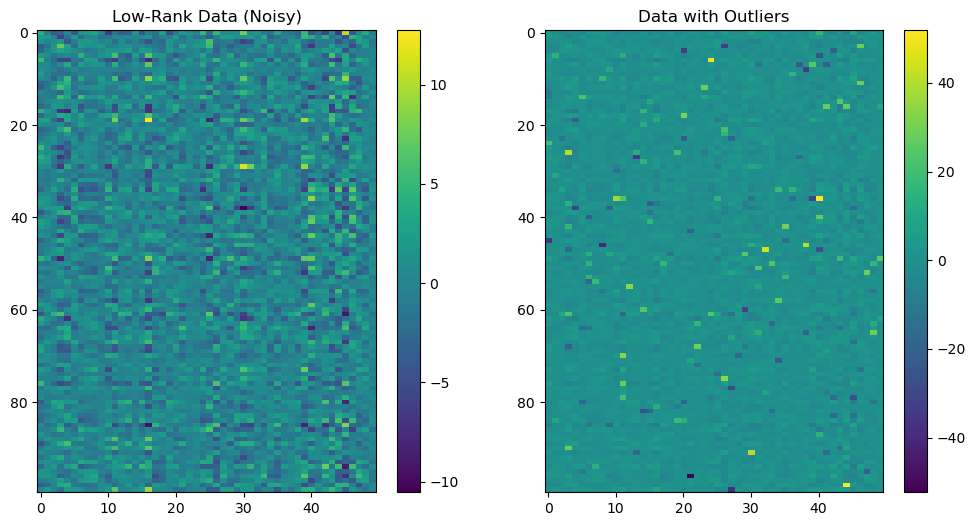

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from rpca import R_pca            # User defined module

def generate_low_rank_data(n_samples=100, n_features=50, rank=5, noise_level=0.1):
    """
    Generate a low-rank matrix with added Gaussian noise.

    Args:
        n_samples (int): Number of samples (rows) in the matrix.
        n_features (int): Number of features (columns) in the matrix.
        rank (int): The rank of the low-rank matrix.
        noise_level (float): Standard deviation of the Gaussian noise to add.

    Returns:
        numpy.ndarray: A low-rank matrix with added noise.
    """
    # Generate two random matrices and multiply them to create a low-rank matrix
    U = np.random.randn(n_samples, rank)
    V = np.random.randn(rank, n_features)
    low_rank_matrix = np.dot(U, V)

    # Add Gaussian noise
    noise = noise_level * np.random.randn(n_samples, n_features)
    noisy_matrix = low_rank_matrix + noise

    return noisy_matrix


def add_sparse_outliers(data, outlier_fraction=0.1, outlier_magnitude=10):
    """
    Add sparse outliers to a given matrix.

    Args:
        data (numpy.ndarray): The input data matrix.
        outlier_fraction (float): The fraction of elements to replace with outliers.
        outlier_magnitude (float): The magnitude of the outliers.

    Returns:
        numpy.ndarray: The data matrix with added sparse outliers.
    """
    n_samples, n_features = data.shape
    n_outliers = int(outlier_fraction * n_samples * n_features)

    # Create a copy of the data to add outliers
    data_with_outliers = np.copy(data)

    # Randomly choose elements to become outliers
    outlier_indices = np.random.choice(n_samples * n_features, n_outliers, replace=False)
    data_with_outliers.flat[outlier_indices] += outlier_magnitude * np.random.randn(n_outliers)

    return data_with_outliers


# Parameters for data generation
n_samples = 100
n_features = 50
rank = 5
noise_level = 0.1
outlier_fraction = 0.05
outlier_magnitude = 20

# Generate low-rank data
low_rank_data = generate_low_rank_data(n_samples, n_features, rank, noise_level)

# Add sparse outliers
data_with_outliers = add_sparse_outliers(low_rank_data, outlier_fraction, outlier_magnitude)

# Visualize the generated data
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Low-Rank Data (Noisy)")
plt.imshow(low_rank_data, aspect='auto', cmap='viridis')
plt.colorbar()

plt.subplot(1, 2, 2)
plt.title("Data with Outliers")
plt.imshow(data_with_outliers, aspect='auto', cmap='viridis')
plt.colorbar()

plt.show()

In [2]:
# Implementing the RPCA-OD
# ========================

# Initialize the R_pca model
rpca = R_pca(data_with_outliers)

# Fit the model
L, S = rpca.fit()

# The low-rank matrix L and the sparse matrix S are returned

Iteration: 1, Error: 1.053023
Iteration: 100, Error: 0.045511
Iteration: 200, Error: 0.060533
Iteration: 300, Error: 0.020849
Iteration: 400, Error: 0.003745
Iteration: 500, Error: 0.000169
Iteration: 587, Error: 0.000033


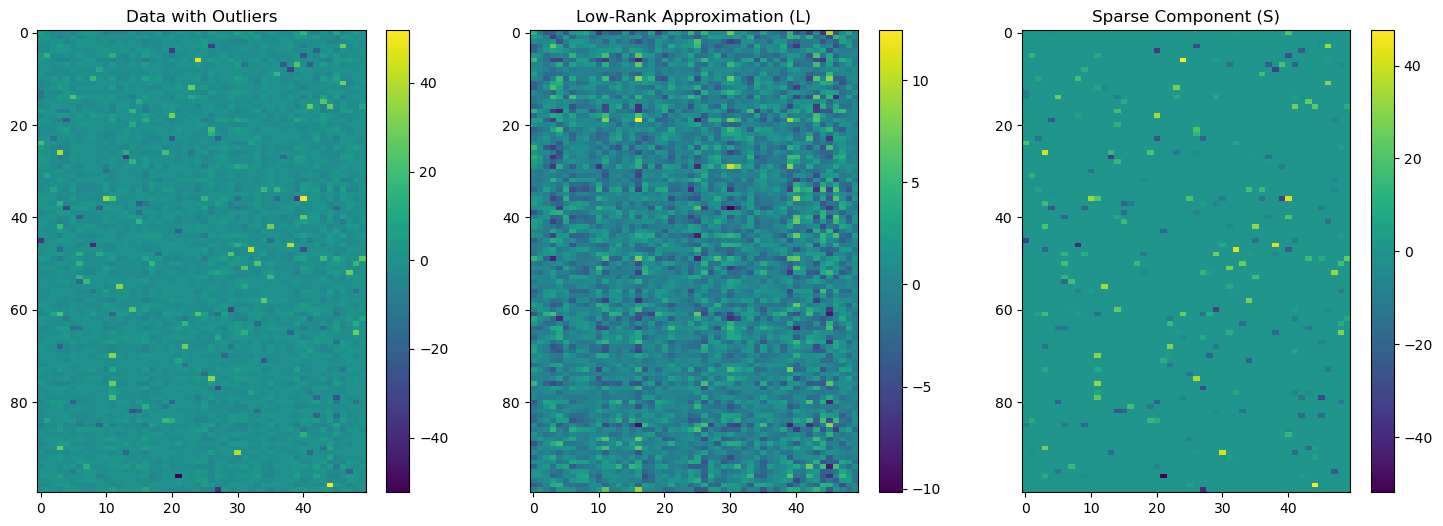

In [3]:
# Visualize the original data with outliers, the low-rank component, and the sparse component (outliers)
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.title("Data with Outliers")
plt.imshow(data_with_outliers, aspect='auto', cmap='viridis')
plt.colorbar()

plt.subplot(1, 3, 2)
plt.title("Low-Rank Approximation (L)")
plt.imshow(L, aspect='auto', cmap='viridis')
plt.colorbar()

plt.subplot(1, 3, 3)
plt.title("Sparse Component (S)")
plt.imshow(S, aspect='auto', cmap='viridis')
plt.colorbar()

plt.show()

In [4]:
outliers = np.argwhere(np.abs(S) > 0)
print("Outliers detected at positions:")
print(outliers)

Outliers detected at positions:
[[ 0  0]
 [ 0  1]
 [ 0  3]
 ...
 [99 47]
 [99 48]
 [99 49]]


Iteration: 1, Error: 1.956720
Iteration: 100, Error: 0.000061
Iteration: 122, Error: 0.000032


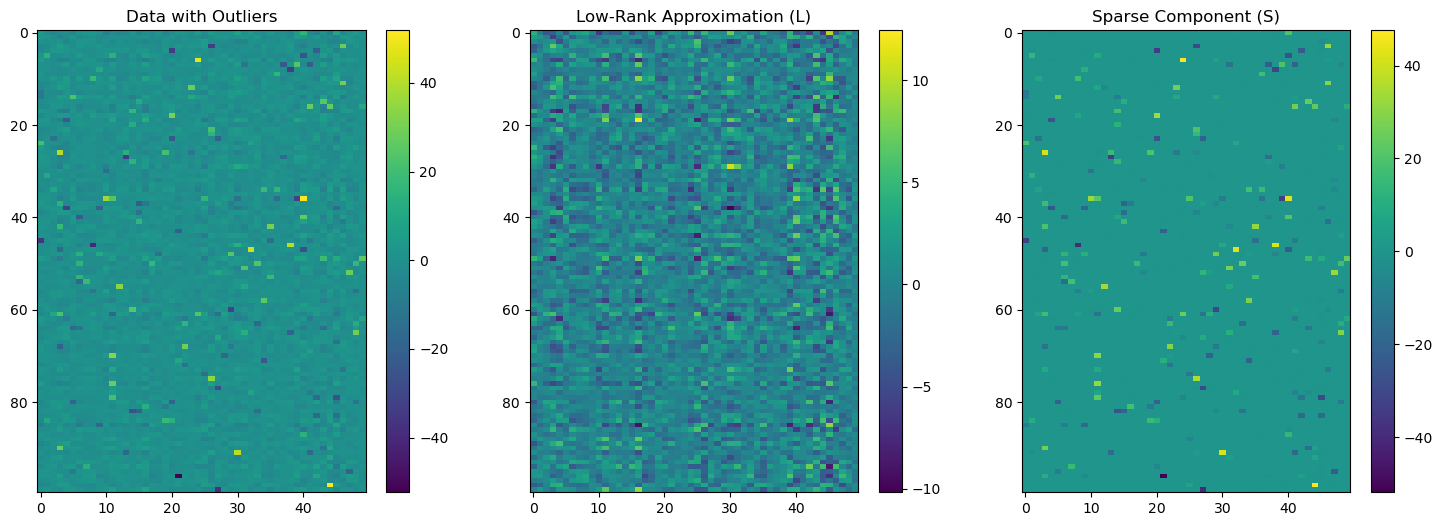

In [5]:
# Fit the model with history tracking
result = rpca.fit_with_convergence()

L = result.L
S = result.S
history = result.history

# Visualize the decomposition results
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.title("Data with Outliers")
plt.imshow(data_with_outliers, aspect='auto', cmap='viridis')
plt.colorbar()

plt.subplot(1, 3, 2)
plt.title("Low-Rank Approximation (L)")
plt.imshow(L, aspect='auto', cmap='viridis')
plt.colorbar()

plt.subplot(1, 3, 3)
plt.title("Sparse Component (S)")
plt.imshow(S, aspect='auto', cmap='viridis')
plt.colorbar()

plt.show()

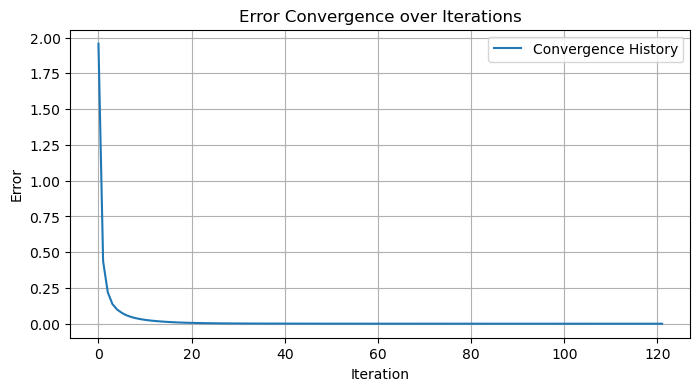

In [6]:
# Plot the convergence history
plt.figure(figsize=(8, 4))
plt.plot(history, label='Convergence History')
plt.title("Error Convergence over Iterations")
plt.xlabel("Iteration")
plt.ylabel("Error")
plt.legend()
plt.grid(True)
plt.show()

## Real-World Example


## Training k-Nearest Neighbors (kNN) for Unsupervised Outlier Detection



---

### Fine-Tune KNN Algorithm


## RPCA in Practice

In this section, we will demonstrate the application of the RPCA algorithm on various benchmark datasets across different domains:

1.	**Computer Vision Dataset**: The well-known MNIST dataset.
2.	**Text Analysis Dataset**:   Amazon Reviews dataset.
3.	**Network Intrusion Detection Dataset**: An intrusions simulated dataset in a military network environment. 

**To do** 

`...` This section will be written later `...`

In [7]:
mnist_path = "../../datasets/Classical/24_mnist.npz"
mnist = np.load(mnist_path, allow_pickle=True)
X, y = mnist['X'], mnist['y']

print(X.shape)
print(y.shape)
print(np.count_nonzero(y)/len(y))

(7603, 100)
(7603,)
0.09206892016309351


In [8]:
amazon_path = "../../datasets/NLP_by_BERT/amazon.npz"
amazon = np.load(amazon_path, allow_pickle=True)
X, y = amazon['X'], amazon['y']

print(X.shape)
print(y.shape)
print(np.count_nonzero(y)/len(y))

(10000, 768)
(10000,)
0.05


In [9]:
## Load Intrusion datasets
train = pd.read_csv("../../datasets/networkIntrosion/Train_data.csv")
test = pd.read_csv("../../datasets/networkIntrosion/Test_data.csv")

print(train.shape)
# print(train.info())

(25192, 42)


In [10]:
print(test.shape)
# print(test.info())

(22544, 41)


In [11]:
# Check the `class` which is the target
print(train.loc[:, "class"].value_counts())

class
normal     13449
anomaly    11743
Name: count, dtype: int64


In [12]:
# Identify categorical and numerical columns
categorical_cols = [col for col in train.columns.to_list() if train[col].dtype=='object' and col !='class']
numerical_cols = [col for col in train.columns if col not in categorical_cols and col !='class']

# Prepare the data
X_train = train.drop(columns=['class']) 
y_train = train['class'].apply(lambda x: 1 if x == 'anomaly' else 0) 

# The X_test
X_test = test

In [13]:
# Apply preprocessing


In [14]:
# Apply KNN

In [15]:
# Visualize the results


## Conclusion

This notebook demonstrates the application of the **K-Nearest Neighbors Outlier Detector (ABOD)** algorithm across multiple contexts. Through theoretical exploration and practical implementation, we have showcased KNN's strengths in detecting anomalies in both artificial and real-world datasets.